# Long-lived RecB spots

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',
                            '230817_1', '230810_1', '230816_1',
                            '230906_2', '230912_1', '230912_2',
                            '230907_1', '230907_2', '230913_1',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec'
                            ],
                    groups=['0', '0', '0', '0', '0', 
                            '3 ng/mL', '3 ng/mL', '3 ng/mL',
                            '10 ng/mL', '10 ng/mL', '10 ng/mL',
                            '20 ng/mL', '20 ng/mL', '20 ng/mL',
                            '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL'
                            ],
                    metadata={'all':'DateTime'},
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230817_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230810_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230816_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230906_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230912_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230912_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230907_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', '

In [ ]:
data.describe()

## JF549 bleaching rates

In [2]:
from pyberries.data import Fit
import seaborn.objects as so

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR',
                    groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset',
                    p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

# (
#     so.Plot(bleaching_fit.data, x='Frame', color='Group')
#     .layout(size=(15, 6))
#     .facet(col='Dataset', wrap=6)
#     .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR')
#     .add(so.Line(linestyle='-'), y='Fit', legend=False)
#     .scale(color='flare')
#     .share(y=False)
#     .limit(x=(None, None), y=(None, None))
#     .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
#     # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
# )

Show fitted parameters

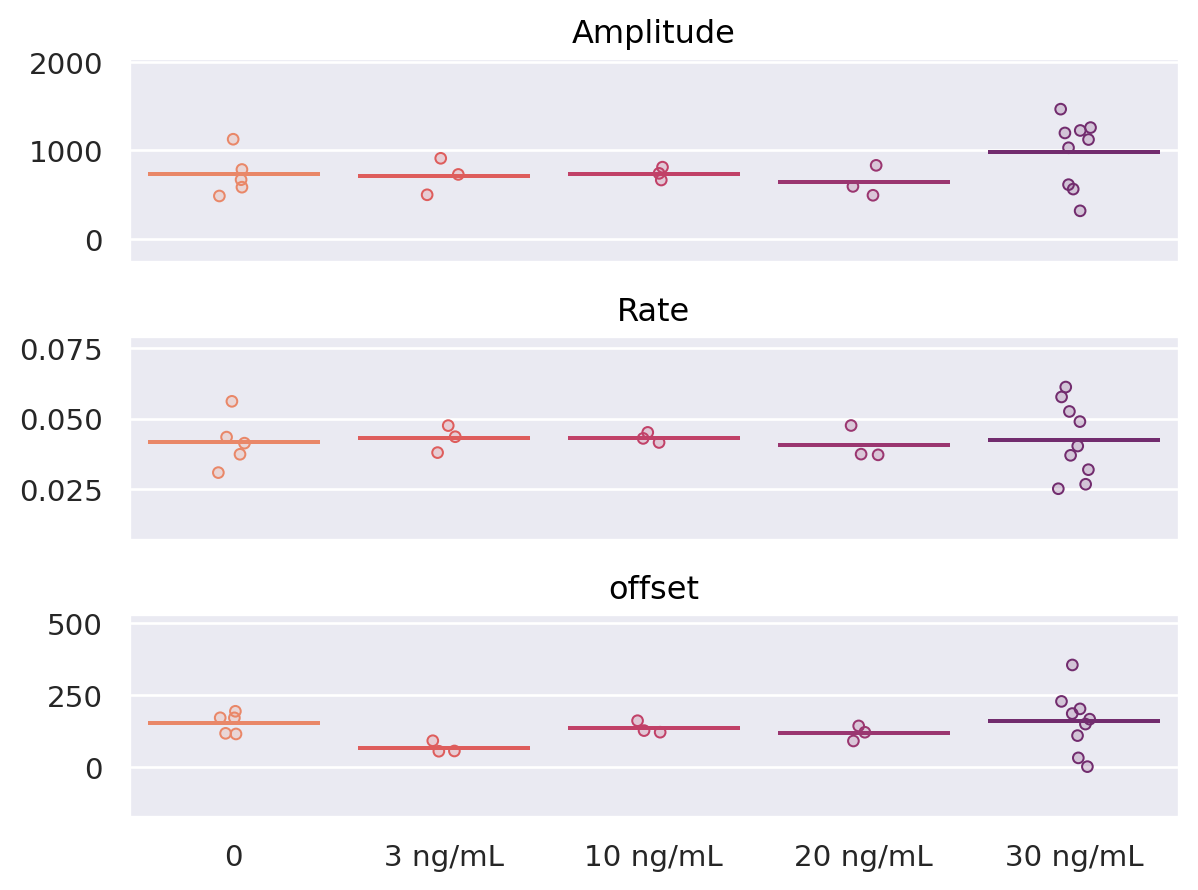

In [3]:
import seaborn.objects as so

(
    so.Plot(bleaching_fit.parameters, x='Group', y='Value', color='Group')
    .facet(row='Parameter')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(), so.Agg(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

Adjust bleaching rates for exposure time

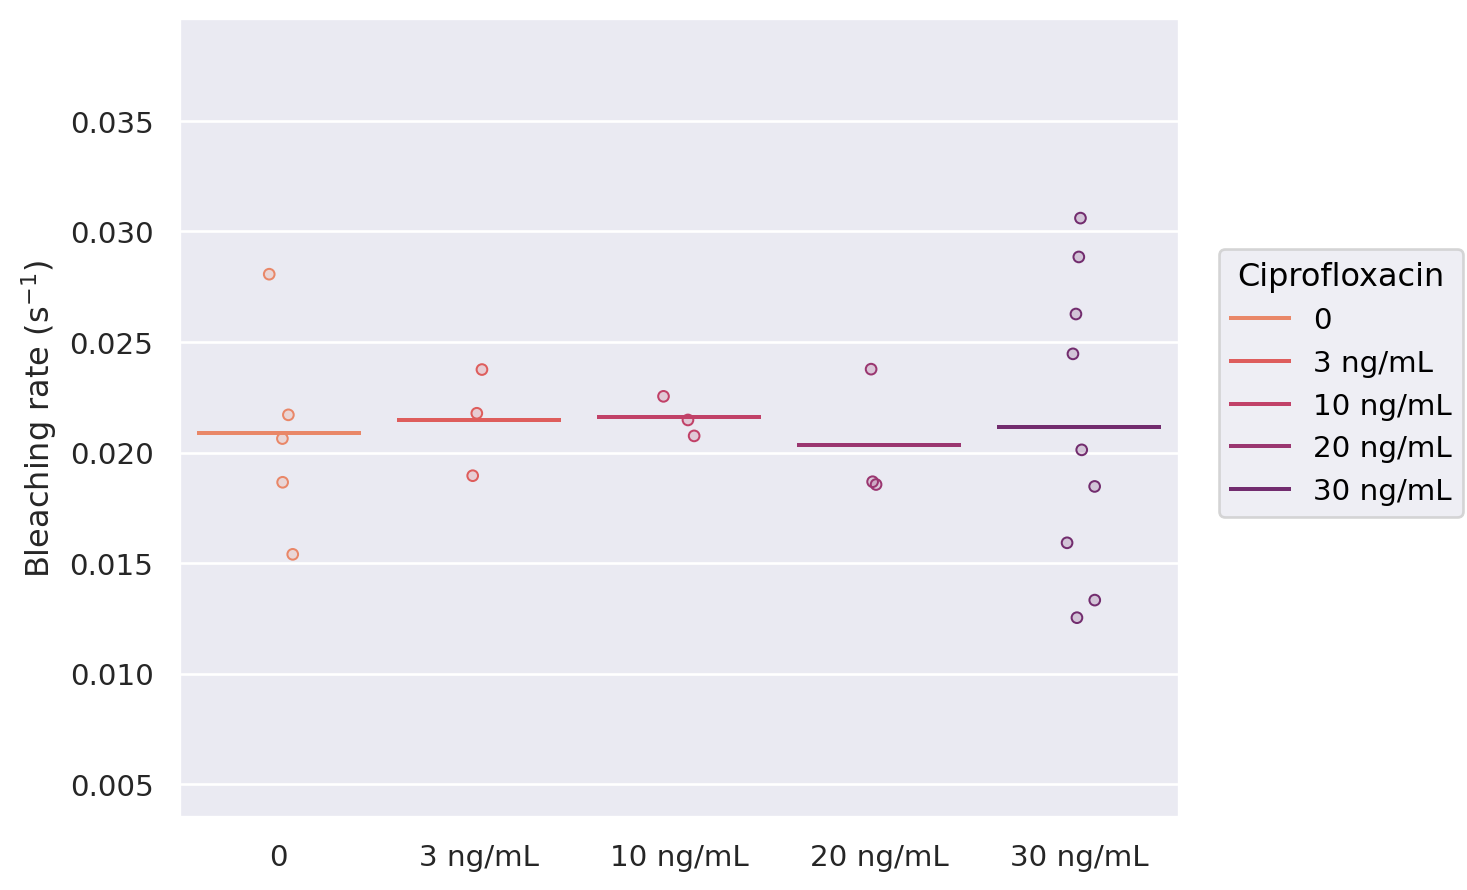

In [4]:
bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))
                   )

(
    so.Plot(bleaching_rates, x='Group', y='Adjusted_rate', color='Group')
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Bleaching rate (s$^{-1}$)", color='Ciprofloxacin')
    .theme({'axes.ymargin':0.5})
    # .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

## RecB binding time on DNA

### A mono-exponential decay model does not fit the histograms well (especially under higher ciprofloxacin)

In [141]:
from pyberries.data import Fit, get_histogram
from pyberries.data import get_model
import pandas as pd
import numpy as np

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 0.1])

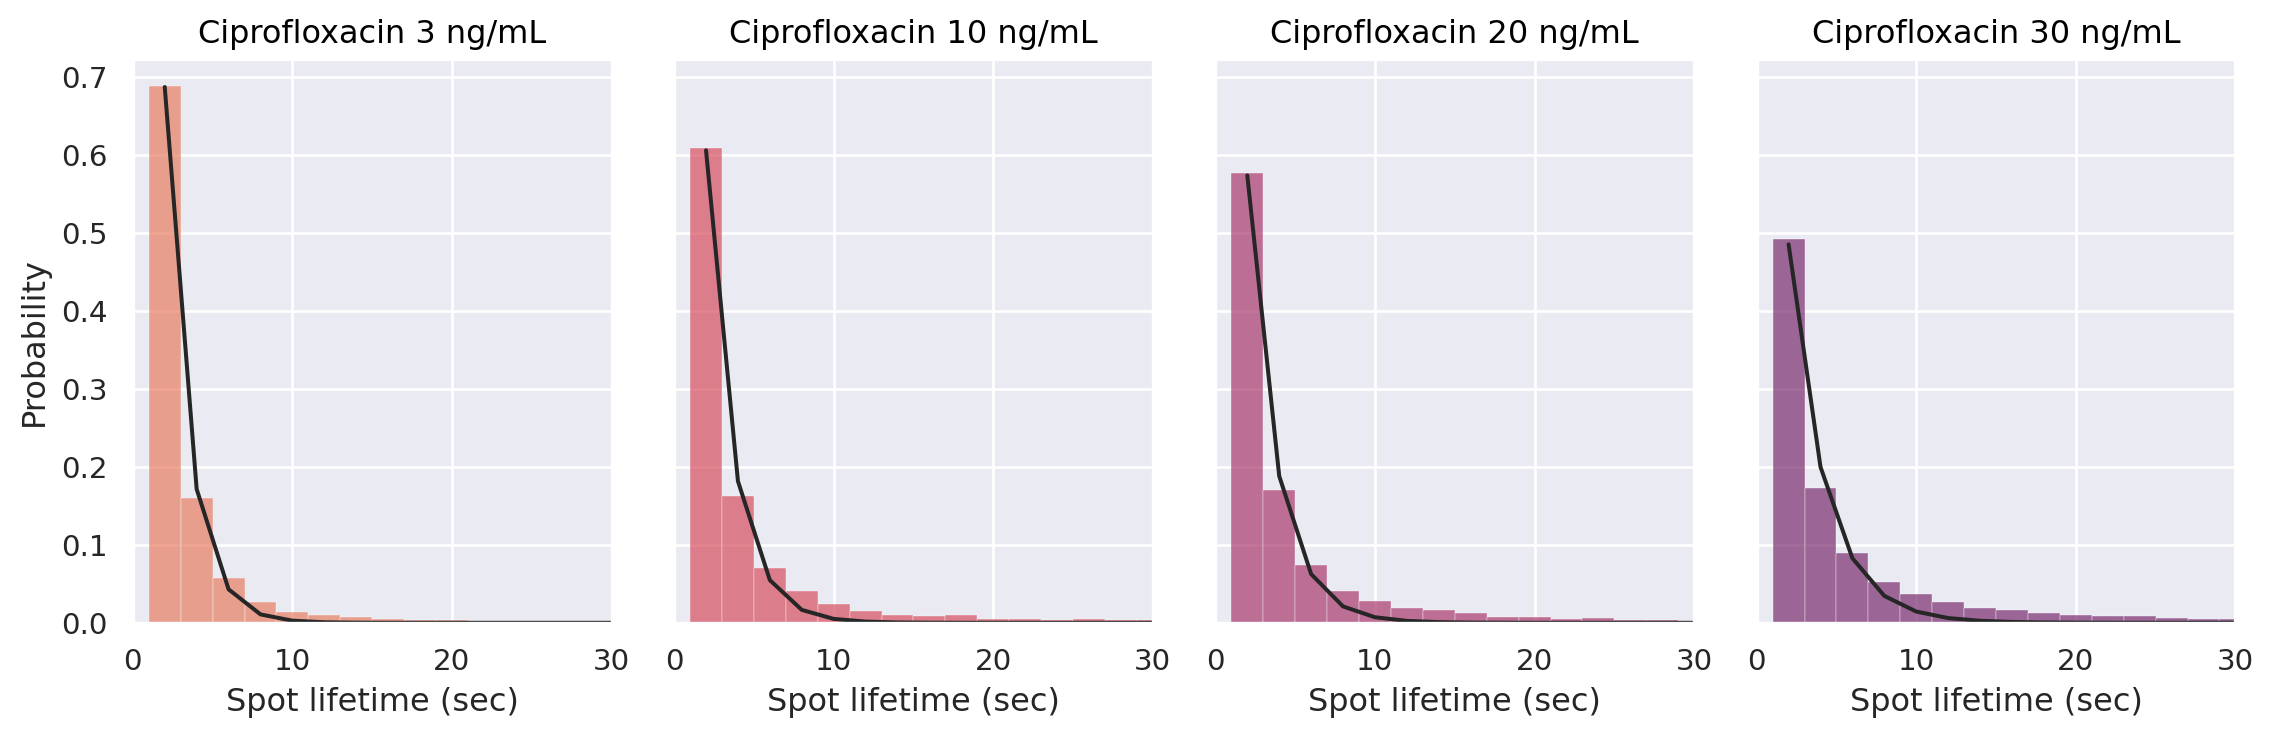

In [145]:
import seaborn.objects as so
from seaborn import plotting_context

df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group != "0"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(12, 4))
    .facet(col='Group', wrap=4)
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    # .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Monoexp_fits_cipro.pdf', format='pdf', bbox_inches='tight')
)

### Fitting with a bi-exponential model gives better results

In [24]:
from pyberries.data import Fit, get_histogram
from pyberries.data import get_model
import pandas as pd
import numpy as np

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'],
                     density=True, discrete=False, binlabels='left')                     
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 1, 0.1, 0.1])


monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

Show the fits (with monoexponential components)

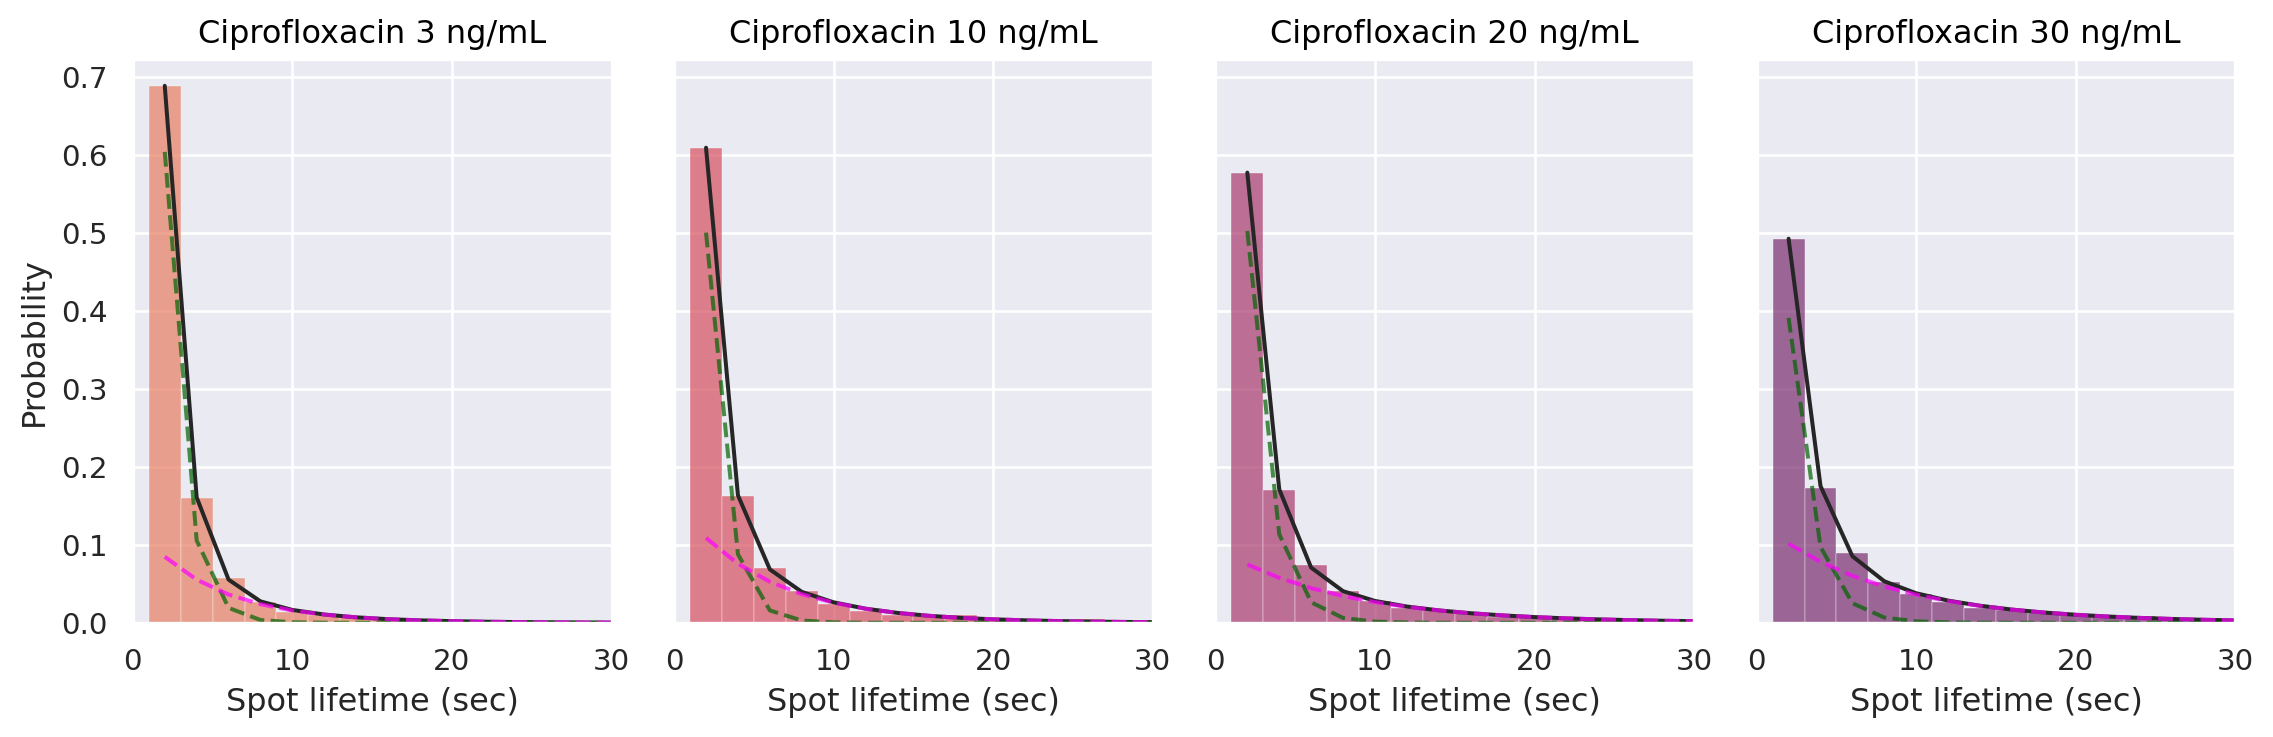

In [6]:
import seaborn.objects as so
from seaborn import plotting_context

df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group != "0"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .layout(size=(12, 4))
    .facet(col='Group', wrap=4)
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    # .theme(plotting_context('talk'))
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

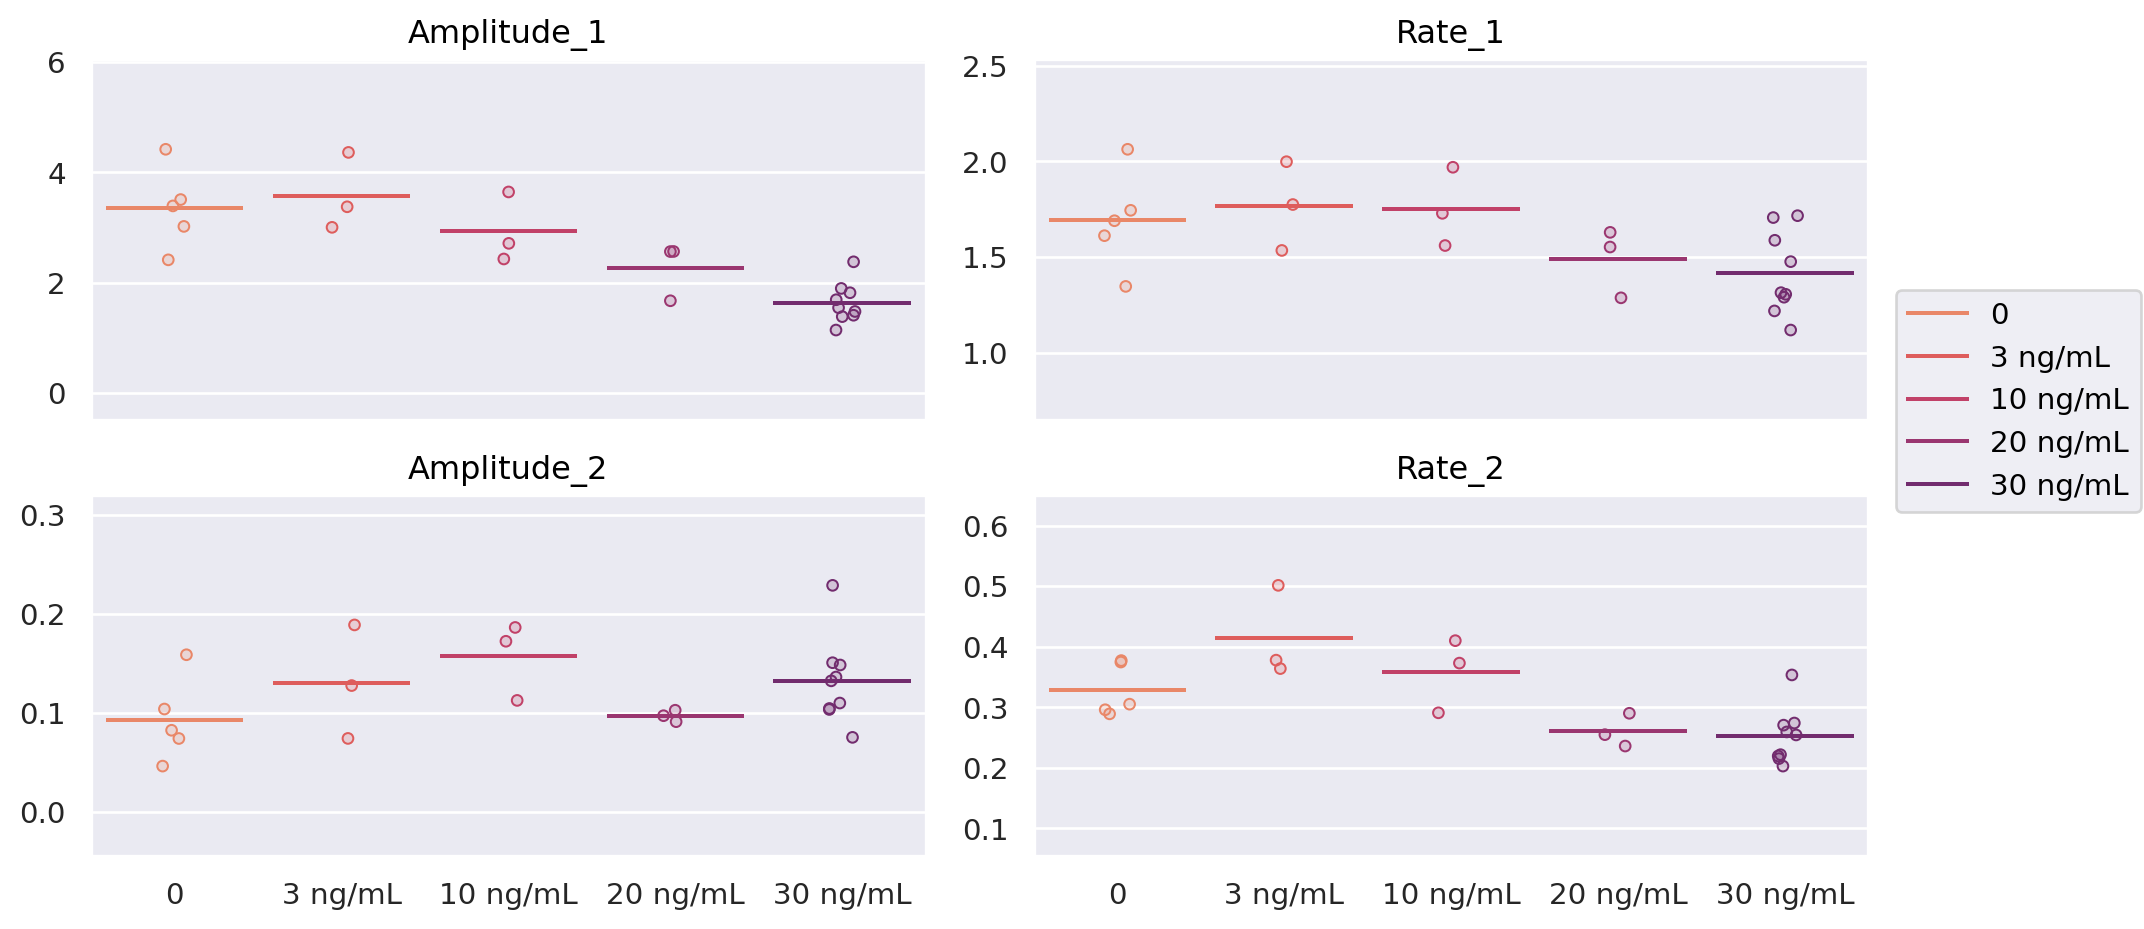

In [7]:
import seaborn.objects as so

(
    so.Plot(lifetime_fit.parameters, x='Group', y='Value', color='Group')
    .layout(size=(10, 5))
    .facet(col='Parameter', wrap=2)
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

In [27]:
display(lifetime_fit.parameters)

,Group,Value,Parameter,Dataset
0,0,3.020139,Amplitude_1,230725_1
1,0,1.612198,Rate_1,230725_1
2,0,0.103897,Amplitude_2,230725_1
3,0,0.374672,Rate_2,230725_1
4,0,3.507442,Amplitude_1,230725_2
...,...,...,...,...
87,30 ng/mL,0.353389,Rate_2,230504_2sec
88,30 ng/mL,1.476149,Amplitude_1,230718_2sec
89,30 ng/mL,1.290617,Rate_1,230718_2sec
90,30 ng/mL,0.103448,Amplitude_2,230718_2sec


In [122]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes = (lifetime_fit
             .parameters
             .copy()
             .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
             .replace({'1':'Short', '2':'Long'})
             .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
             .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
             .reset_index()
             .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                     Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                     Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                     Population_Short=lambda df: 100 - df.Population_Long
                     )
             .drop(columns=['Value', 'Value_bleaching'], level=0)
             .droplevel(['Parameter', 'Rate_type'], axis=1)
             .melt(id_vars=['Group', 'Dataset'])
             .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
             .drop(columns='variable')
             .assign(Group=lambda df: df.Group
                                        .astype('category')
                                        .cat.set_categories(['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'], ordered=True))
             .sort_values('Group')
             )

Spot lifetimes (both short and long-lived spots)

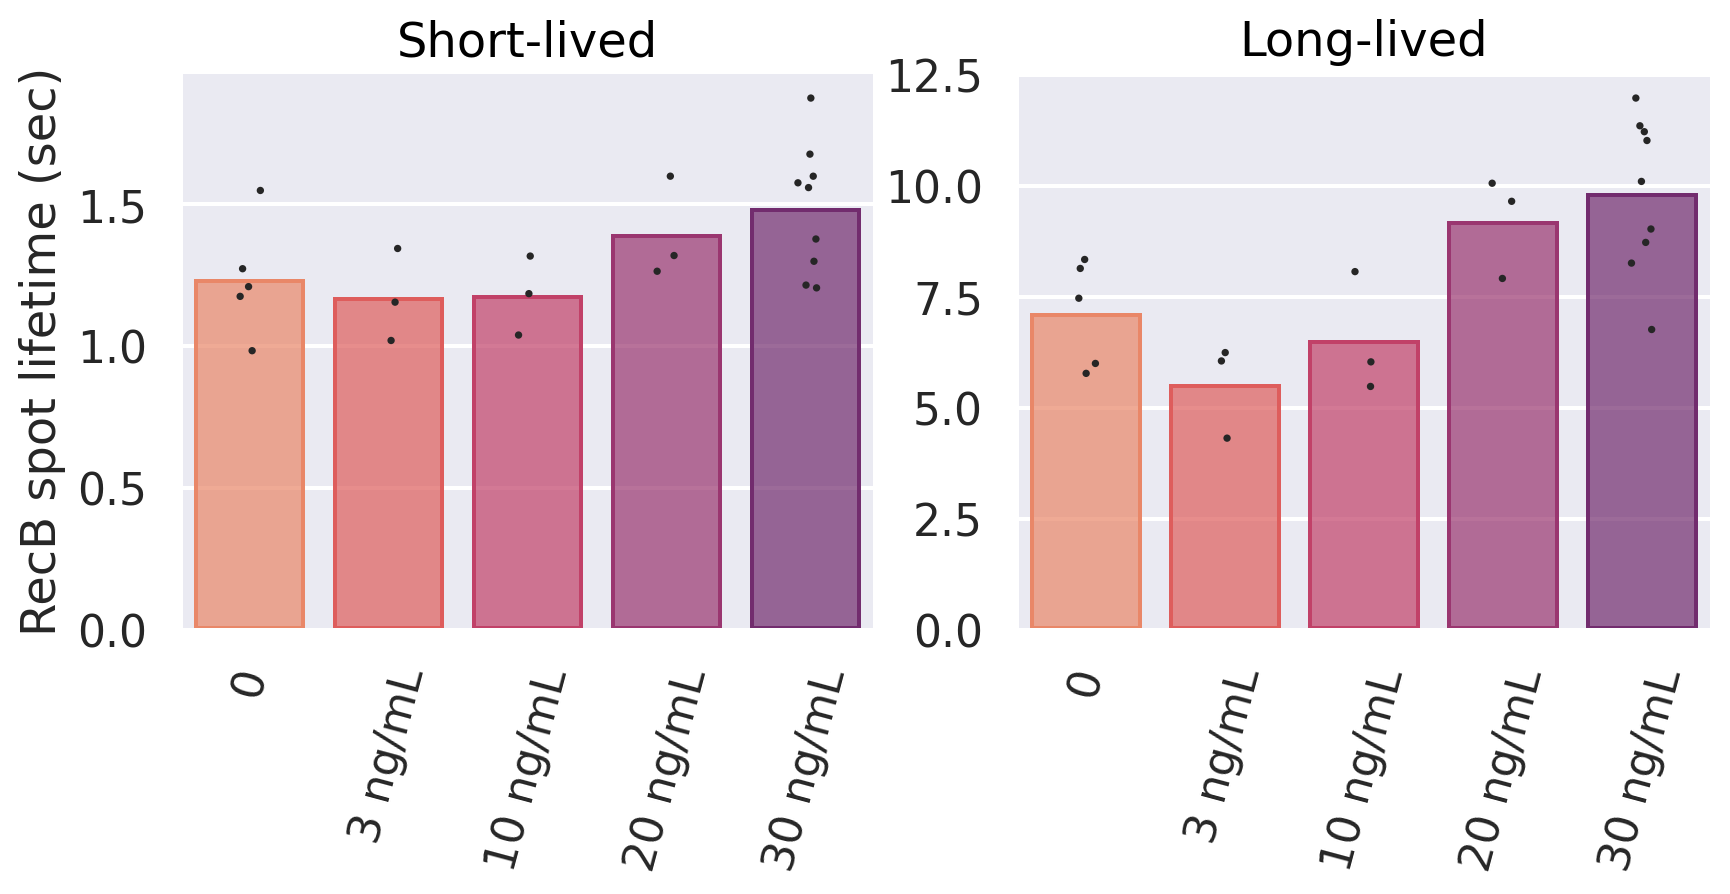

In [105]:
from seaborn import plotting_context
import numpy as np

p = (
    so.Plot(lifetimes.query('Parameter == "Lifetime"'), x='Group', y='value', color='Group')
    .layout(size=(9.5,5))
    .facet(col='Rate_type')
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare'))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="RecB spot lifetime (sec)", color='Ciprofloxacin', title='{}-lived'.format)
    .theme(plotting_context('talk'))
    .plot()
)

p._figure.axes[0].xaxis.set_tick_params(rotation=75)
p._figure.axes[1].xaxis.set_tick_params(rotation=75)

display(p)
# p.save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')

Proportion of long-lived spots

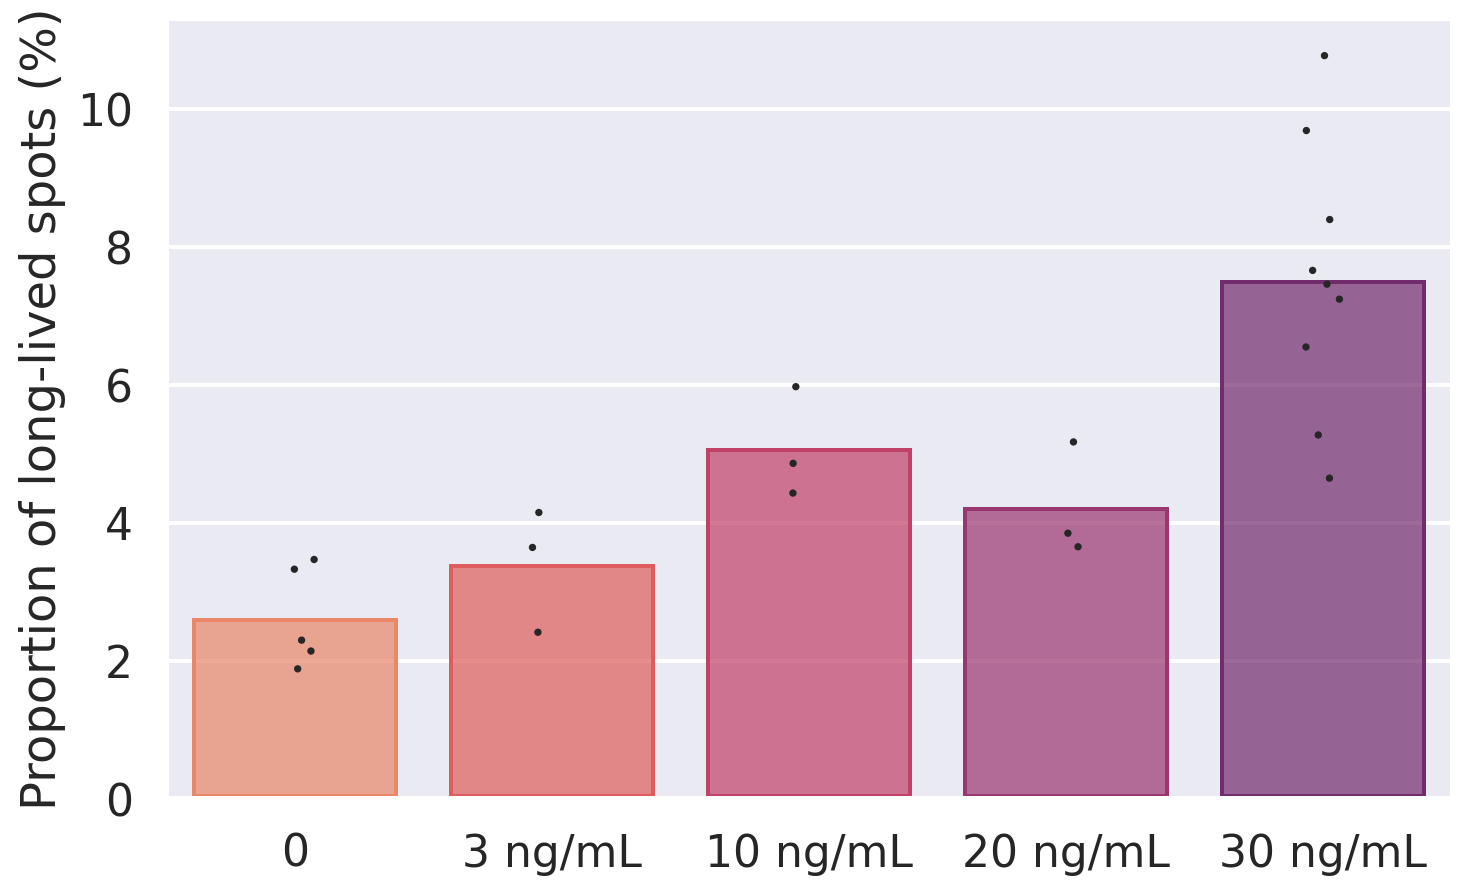

In [106]:
from seaborn import plotting_context
import pandas as pd

(
    so.Plot(lifetimes.query('Parameter == "Population"'), x='Group', y='value', color='Group')
    .layout(size=(8,5))
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

Fit parameters table

In [138]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Group', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_mean', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_mean', 'Population_std'], new='Proportion (\%)', delimiter=' $\pm$ '))
      [['Lifetime (sec)', 'Proportion (\%)']]
      .rename_axis(['Ciprofloxacin', 'Population'])
      .reindex(['Short', 'Long'], level=1)
      )

display(df)
print(df.to_latex())

Lifetime (sec)   Proportion (\%)
Ciprofloxacin Population                                   
0             Short        1.24 $\pm$ 0.2  97.38 $\pm$ 0.72
              Long         7.15 $\pm$ 1.2   2.62 $\pm$ 0.72
3 ng/mL       Short       1.17 $\pm$ 0.16   96.6 $\pm$ 0.89
              Long        5.54 $\pm$ 1.06    3.4 $\pm$ 0.89
10 ng/mL      Short       1.18 $\pm$ 0.14   94.91 $\pm$ 0.8
              Long        6.53 $\pm$ 1.36    5.09 $\pm$ 0.8
20 ng/mL      Short       1.39 $\pm$ 0.18  95.78 $\pm$ 0.83
              Long        9.21 $\pm$ 1.14   4.22 $\pm$ 0.83
30 ng/mL      Short       1.49 $\pm$ 0.23  92.48 $\pm$ 1.95
              Long        9.83 $\pm$ 1.74   7.52 $\pm$ 1.95

\begin{tabular}{llll}
\toprule
 &  & Lifetime (sec) & Proportion (\%) \\
Ciprofloxacin & Population &  &  \\
\midrule
\multirow[t]{2}{*}{0} & Short & 1.24 $\pm$ 0.2 & 97.38 $\pm$ 0.72 \\
 & Long & 7.15 $\pm$ 1.2 & 2.62 $\pm$ 0.72 \\
\cline{1-4}
\multirow[t]{2}{*}{3 ng/mL} & Short & 1.17 $\pm$ 0.16 & 96.6 $\pm$ 0.89 \\
 & Long & 5.54 $\pm$ 1.06 & 3.4 $\pm$ 0.89 \\
\cline{1-4}
\multirow[t]{2}{*}{10 ng/mL} & Short & 1.18 $\pm$ 0.14 & 94.91 $\pm$ 0.8 \\
 & Long & 6.53 $\pm$ 1.36 & 5.09 $\pm$ 0.8 \\
\cline{1-4}
\multirow[t]{2}{*}{20 ng/mL} & Short & 1.39 $\pm$ 0.18 & 95.78 $\pm$ 0.83 \\
 & Long & 9.21 $\pm$ 1.14 & 4.22 $\pm$ 0.83 \\
\cline{1-4}
\multirow[t]{2}{*}{30 ng/mL} & Short & 1.49 $\pm$ 0.23 & 92.48 $\pm$ 1.95 \\
 & Long & 9.83 $\pm$ 1.74 & 7.52 $\pm$ 1.95 \\
\cline{1-4}
\bottomrule
\end{tabular}



## Figures

### Number of RecB spots

Normalised over cell length and number of cells

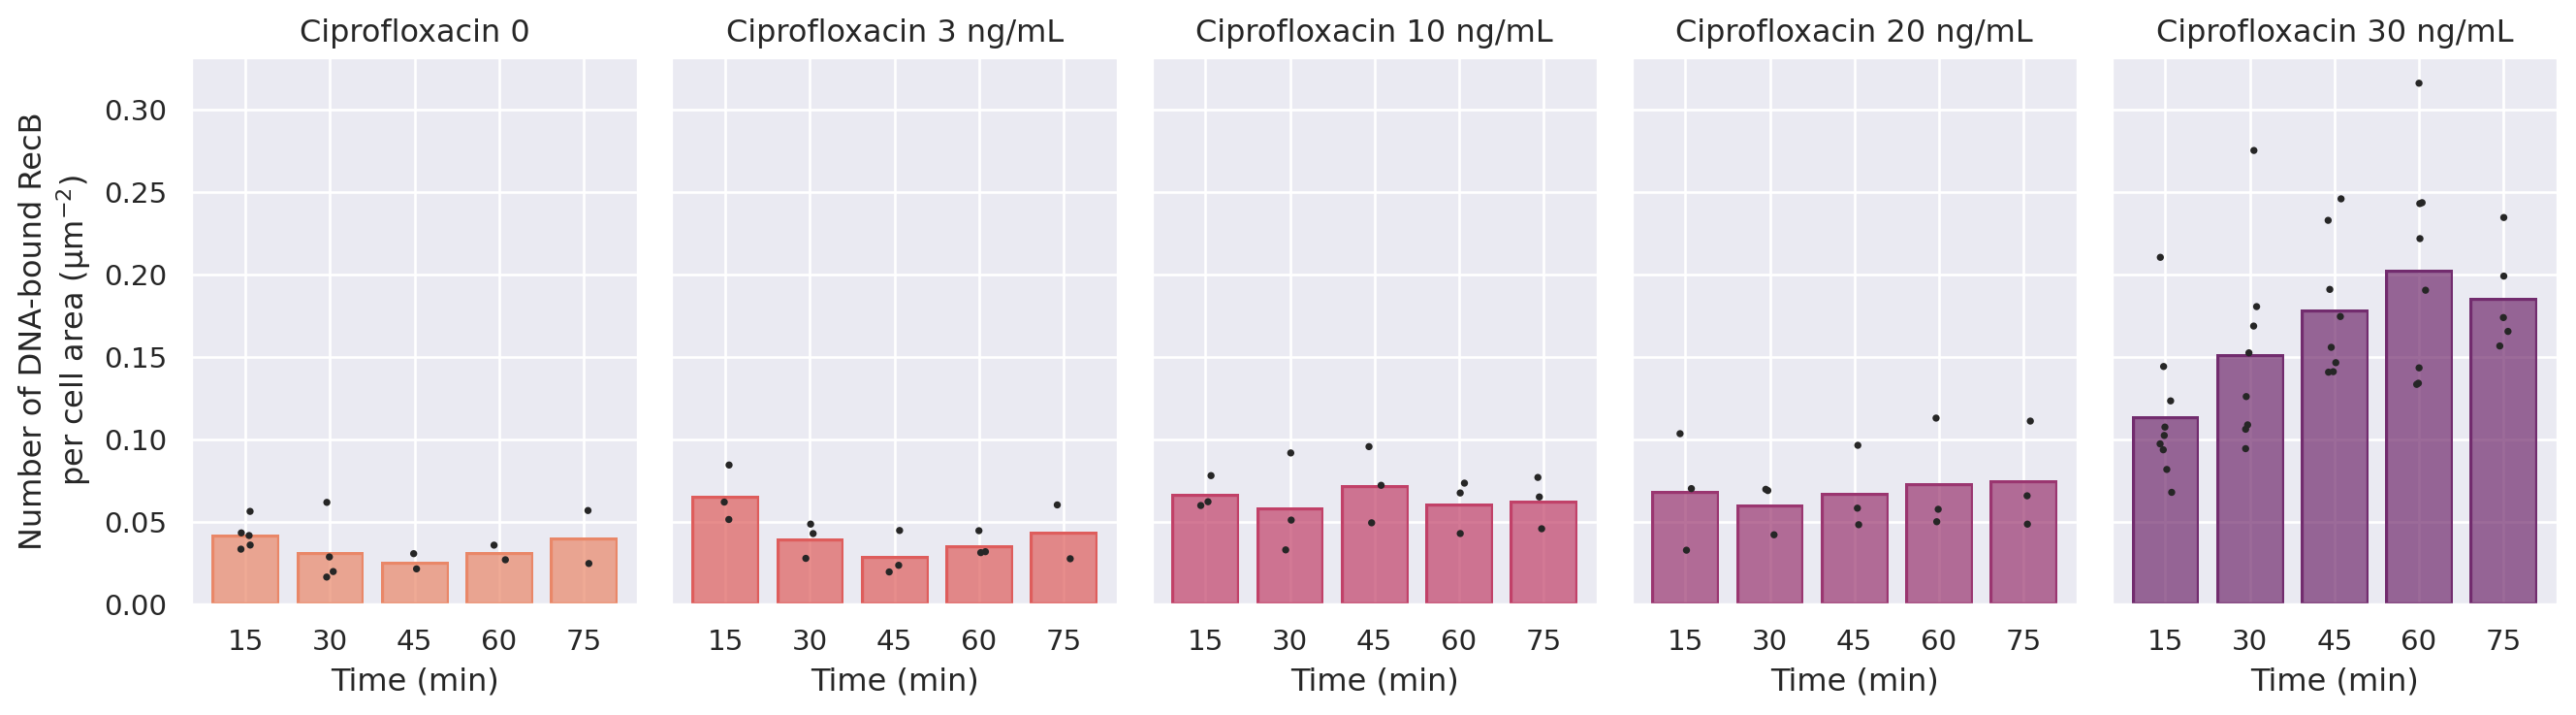

In [7]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots',
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'Area': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area)
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'long_spot'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells
              )
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Group')
 .layout(size=(14, 4))
 .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
 .add(so.Bar(), so.Agg(), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(alpha=so.Nominal(), color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of DNA-bound RecB\nper cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
 .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Cipro_num_spots.svg', format='svg', bbox_inches='tight')
 )

Without splitting long/short spots:

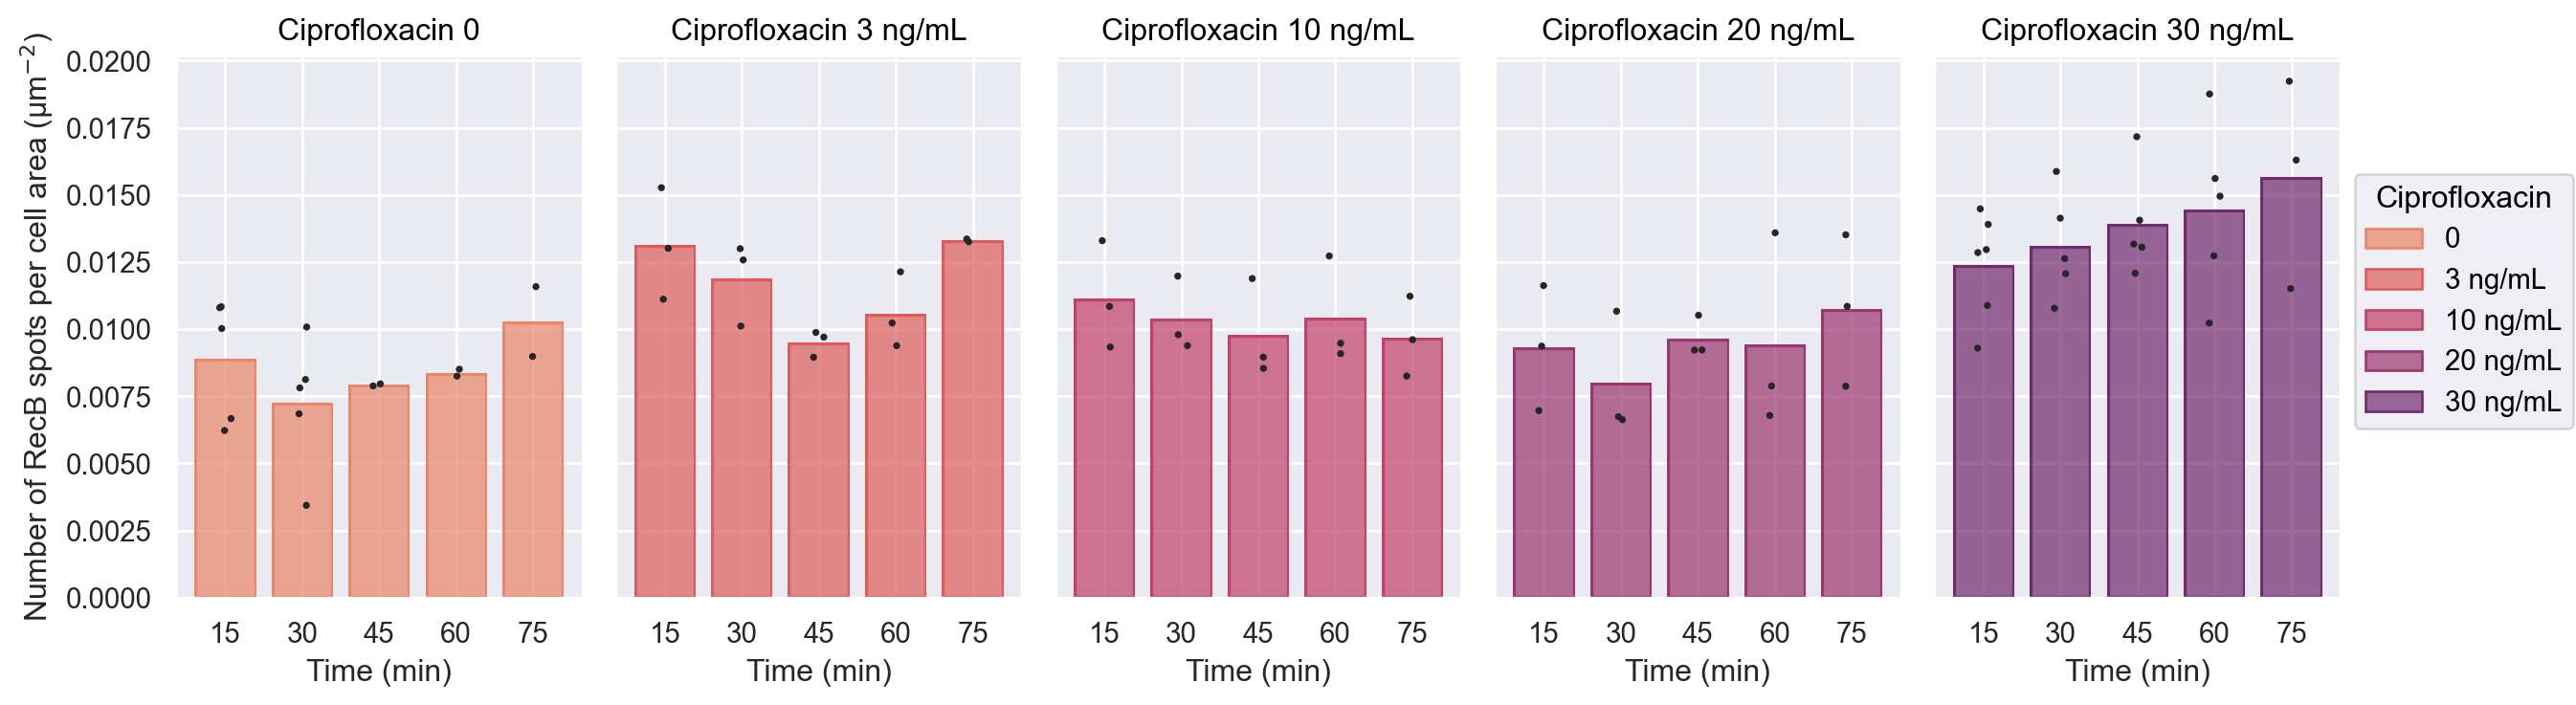

In [4]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'ParentIndices']) # Group per cell
      .agg({'Indices': 'count', 'Area': 'mean'}) # Count number of spots (trackheads only, so we're not biased by track length) per cell
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area) # Normalise spot count by cell Area
      .groupby(by=['Group', 'Dataset', 'Time_min_bin'])
      .agg({'norm_count': 'sum'}) # Sum all spots for each bin (can't do a mean, otherwise it would exclude cells with 0 spots)
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None)) # Add the number of cells for each bin (including those that have 0 spots)
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(norm_count=lambda df: df.norm_count / df.nCells) # Divide the total count by the number of cells in the bin
      .query('Time_min_bin < 90')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Group')
 .layout(size=(13, 4))
 .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
 .add(so.Bar(), so.Agg())
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
#  .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

Inspect individual datasets:

array(['230118_DT23', '230720_1', '230720_2', '230726_cipro30',
       '230824_1', '230829_1', '230201_DT23', '230504_2sec',
       '230718_2sec'], dtype=object)

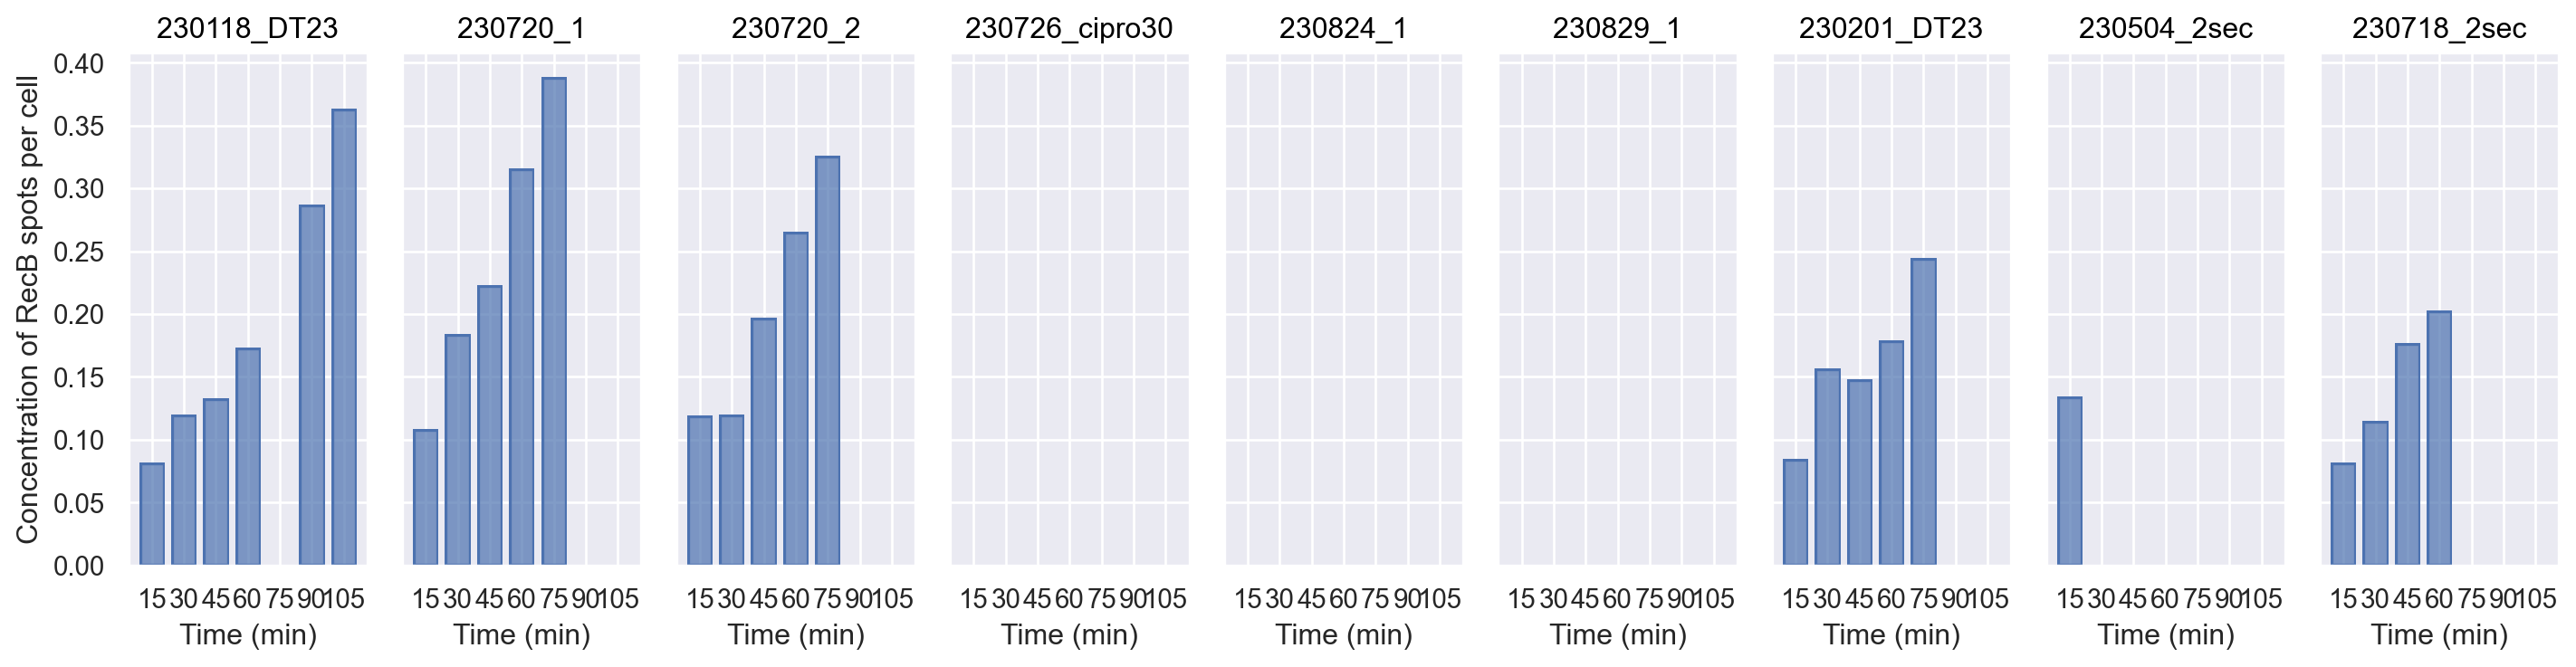

In [34]:
df = data.Bacteria_large.query('Group == "30 ng/mL"')

display(df.Dataset.unique())

(
 so.Plot(df, x='Time_min_bin', y='RecBSpotCount')
 .layout(size=(15, 4))
 .facet(col='Dataset')
 .add(so.Bar(), so.Agg())
 .scale(alpha=so.Nominal(), x=so.Continuous().tick(every=15))
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Concentration of RecB spots per cell")
 )

### RecB spot position

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

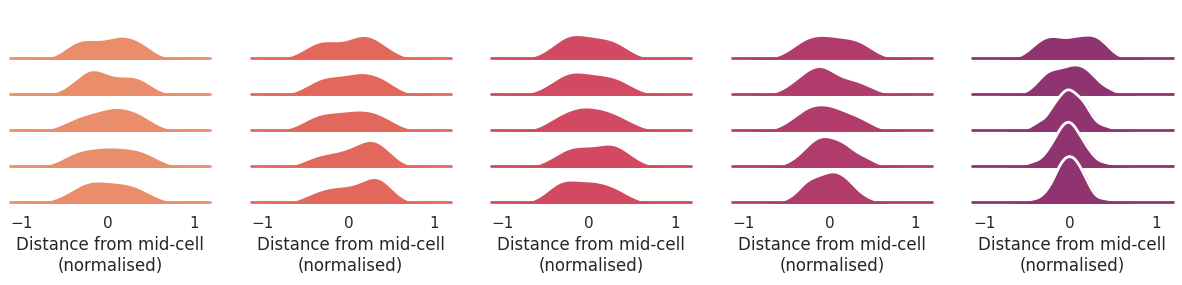

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', 
              midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5,
              )
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=15, binlabels='left')
      .set_type(object_name='RecB_spots', type_dict={'Time_min_bin':'int'})
      .RecB_spots
      .query('Time_min_bin < 90 and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue='Group', aspect=6, height=.5, palette=sns.color_palette('flare'))

# Draw the densities in a few steps
g.map(sns.kdeplot, "midCellDist",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "midCellDist", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

# g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)

plt.savefig(fname='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/RecB_position.svg', format='svg', bbox_inches='tight')